In [1]:
# Benchmark all the different variants of dace convolution
# Benchmark it with respect to cudnn, tensorflow's conv2D
# 1DConv, 2DConv, 3DConv
# Verification and benchmarking

In [2]:
from torch import nn
import click
import dace
import numpy as np
from pprint import pprint
import dace.libraries.blas
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob
import os

/home/akanksha/spcl/dacelocal/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Functions for plotting

def barplot(title, labels=False):
    x = list(sorted(TIMES.keys()))
    bars = [np.median(TIMES[key].timings) for key in x]
    yerr = [np.std(TIMES[key].timings) for key in x]
    color = [('#86add9' if 'dace' in key else 'salmon') for key in x]

    p = plt.bar(x, bars, yerr=yerr, color=color)
    plt.ylabel('Runtime [s]'); plt.xlabel('Implementation'); plt.title(title); 
    if labels:
        plt.gca().bar_label(p)
    pass

def barplotvalues(title, labels=False):
    x = list(sorted(TIMES.keys()))
    bars = [np.median(TIMES[key]) for key in x]
    yerr = [np.std(TIMES[key]) for key in x]
    color = [('#86add9' if 'dace' in key else 'salmon') for key in x]

    p = plt.bar(x, bars, yerr=yerr, color=color)
    plt.ylabel('Runtime [s]'); plt.xlabel('Implementation'); plt.title(title); 
    if labels:
        plt.gca().bar_label(p)
    pass

In [4]:
# Define symbolic sizes for arbitrary inputs
rows = dace.symbol('rows')
cols = dace.symbol('cols')
indepth = dace.symbol('indepth')
inputimages = dace.symbol('inputimages')
outdepth = dace.symbol('outdepth')
chunklength = dace.symbol('chunklength', dtype=dace.int64, integer=True, positive=True)

w = dace.symbol('w')

# Define data type to use
dtype = dace.float64
np_dtype = np.float64

In [5]:
# Different convolution variants

# Simple convolution
@dace.program(auto_optimize=True, device=dace.DeviceType.GPU)
def dace_simple(Input: dtype[inputimages, rows, cols, indepth], 
                      kernel: dtype[ w, w, indepth, outdepth], 
                      Output: dtype[inputimages, rows, cols, outdepth]):
    Output[:] = 0
    for i,j,d,od,m,n in dace.map[w/2:rows-w/2, w/2:cols-w/2,0:indepth,0:outdepth, 0:w, 0:w]:
            Output[0, i, j, od] += Input[0, i - w / 2 + m, j - w / 2 + n, d] * kernel[ m, n, d, od]




# Split into parallel and non parallel maps
# TODO: Find why auto optimize is not working for simpleparallel
@dace.program(device=dace.DeviceType.GPU)
def dace_simpleparallel(Input: dtype[inputimages, rows, cols, indepth],
                              kernel: dtype[ w, w, indepth, outdepth],
                              Output: dtype[inputimages, rows, cols, outdepth]
                              ):
    Output[:] = 0

    for i, j, od in dace.map[w/2:rows-w/2, w/2:cols-w/2, 0:outdepth]:
        tmp = np.zeros([1], dtype = Input.dtype)
        for d,m,n in dace.map[0:indepth,0:w,0:w]:
            tmp = tmp + Input[0, i - w / 2 + m, j - w / 2 + n, d] * kernel[m, n, d, od]
        Output[0,i,j,od] = tmp

        
# TODO: Function returns incorrect values for last rows. Debug the error.
@dace.program(auto_optimize=True, device=dace.DeviceType.GPU)
def dace_allreduce(Input: dtype[inputimages, rows, cols, indepth], 
                           kernel: dtype[ w, w, indepth, outdepth], 
                           Output: dtype[inputimages, rows, cols, outdepth]):
    tmp = np.zeros([inputimages, rows, cols, indepth*w*w, outdepth], dtype = Input.dtype)
    for i,j,d,od,m,n in dace.map[w/2:rows-w/2, w/2:cols-w/2,0:indepth,0:outdepth, 0:w, 0:w]:
        with dace.tasklet:
            in_A << Input[0, i - w/2 + m, j - w/2 + n, d]
            in_B << kernel[m, n, d, od]
            out >> tmp[0, i, j, (d*(w*w)) + (m*w)+n, od]
            out = in_A * in_B

    dace.reduce(lambda a,b:a+b, tmp, Output, axis=3, identity=0)

In [22]:
# Prepare data with numpy
InputImages = 1
Rows = 9
Cols = 9
InChannels = 1
OutChannels = 2
W = 3
Stride = 1 # TODO: Code dace convolutions with stride

# Prepare data with numpy
Input = np.random.rand(InputImages, Rows, Cols, InChannels).astype(np_dtype)
kernel = np.random.rand(W, W, InChannels, OutChannels).astype(np_dtype)
Output = np.zeros((InputImages, Rows, Cols, OutChannels), dtype=np_dtype)

In [23]:
# Verification
input = tf.convert_to_tensor(Input)
filter = tf.convert_to_tensor(kernel)

op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding="VALID")


def verify_with_ref(dace_fun, dace_fun_name, refop, Input, kernel, Output, W):
    dace_fun(Input, kernel, Output)
    opdace = tf.convert_to_tensor(Output)
    opdace = opdace[:,int(W/2):Rows-int(W/2),int(W/2):Cols-int(W/2),:]
    if(sum(sum(sum(sum(opdace-op))))==0):
        print(f"Verification successfull for {dace_fun_name}")
    else:
        print(f"!!! Incorrect convolution for {dace_fun_name}")

verify_with_ref(dace_simple, 'dace_simple', op, Input, kernel, Output, W)
verify_with_ref(dace_simpleparallel, 'dace_simpleparallel', op, Input, kernel, Output, W)
verify_with_ref(dace_allreduce, 'dace_allreduce', op, Input, kernel, Output, W)

Verification successfull for dace_simple
Verification successfull for dace_simpleparallel
!!! Incorrect convolution for dace_allreduce


In [8]:
# Place holder function for tf reference code for profiling.
def timetfgpu():
    op=tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='VALID')
    
# Warmup
%timeit -r 1 -n 1 dace_allreduce(Input, kernel, Output)
%timeit -r 1 -n 1 dace_simple(Input, kernel, Output)
%timeit -r 1 -n 1 dace_simpleparallel(Input, kernel, Output)
%timeit -r 1 -n 1 timetfgpu()

59.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
43.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
25.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


42.2 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.1 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.9 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
144 µs ± 112 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


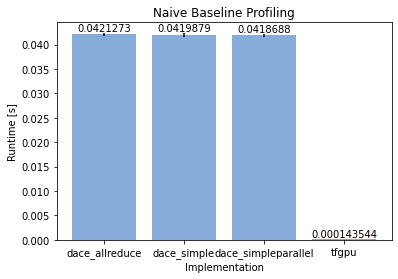

In [9]:
# Naive profiling of baselines
TIMES = {}
TIMES['dace_simple'] = %timeit -o dace_simple(Input, kernel, Output)
TIMES['dace_allreduce'] = %timeit -o dace_allreduce(Input, kernel, Output)
TIMES['dace_simpleparallel'] = %timeit -o dace_simpleparallel(Input, kernel, Output)
TIMES['tfgpu'] = %timeit -o timetfgpu()

barplot('Naive Baseline Profiling', labels=True)


Profiling...
Profiling: 100%|████████████████████████████| 100/100 [00:00<00:00, 7642.54it/s]
DaCe 0.11969449997195625 ms

Profiling...
Profiling: 100%|███████████████████████████| 100/100 [00:00<00:00, 16000.85it/s]
DaCe 0.05869149993031897 ms

Profiling...
Profiling: 100%|██████████████████████████| 100/100 [00:00<00:00, 110580.12it/s]
DaCe 0.00560700004825776 ms
143 µs ± 109 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


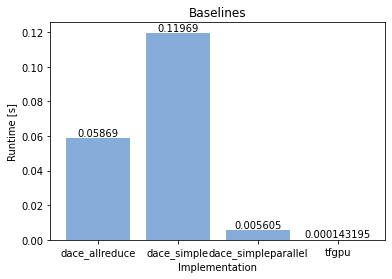

In [10]:
# Dace profiling method, Returns median values in ms
def rundaceprofiling(dace_fun, dace_fun_name, reps):
    # Temporarily set the DACE_profiling config to True
    with dace.config.set_temporary('profiling', value=True):
        # You can control the number of times a program is run with the treps configuration
        with dace.config.set_temporary('treps', value=reps):
            dace_fun(Input,kernel,Output)
    dace_profile_fun = dace_fun_name
    list_of_files = glob.glob(f'.dacecache/{dace_profile_fun}/profiling/results-*.csv')
    latest_file = max(list_of_files, key=os.path.getctime)
    df = pd.read_csv(latest_file)
    return df['Runtime_sec'].median()*1000

TIMES = {}
nrepeat = 100
TIMES['dace_simple'] = rundaceprofiling(dace_simple, 'dace_simple', nrepeat)
TIMES['dace_allreduce'] = rundaceprofiling(dace_allreduce, 'dace_allreduce', nrepeat)
TIMES['dace_simpleparallel'] = rundaceprofiling(dace_simpleparallel, 'dace_simpleparallel', nrepeat)
x = %timeit -o timetfgpu()
TIMES['tfgpu'] = np.median(x.timings) 

barplotvalues("Baselines", True)

Running benchmark for conv2D
Verification successfull for dace_simpleparallel
44 ms ± 2.69 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
405 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Profiling...
Profiling: 100%|███████████████████████████| 100/100 [00:00<00:00, 89679.37it/s]
DaCe 0.008563999926991528 ms
152 µs ± 849 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Verification successfull for dace_simpleparallel
43.1 ms ± 968 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
413 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Profiling...
Profiling: 100%|███████████████████████████| 100/100 [00:00<00:00, 26952.22it/s]
DaCe 0.03408700013096677 ms
152 µs ± 422 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


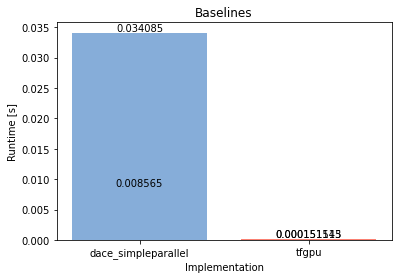

In [26]:
# Trying out code to convert this to a script
import pandas as pd
import json

# Parameterize the code to take a csv file as an input arg
# Maybe write a script which goes through these csvs one by one and generates the reports for each of them
header = ["InputDepth", "InputRow", "InputCol", "OutputDepth", "KernelRow", "KernelCol", "Stride"]
convparams = pd.read_csv("convparam/sample.csv")
convparams = pd.DataFrame(convparams, columns=header)

print("Running benchmark for conv2D")

# Reset index to iterate through each 2D convolution parameter from the csv file
convparams = convparams.reset_index()

ALLPARAMSTIMES = {}
for index, currconv in convparams.iterrows():    
    # Extract parameters to prepare data for convolution
    InputImages = 1
    Rows = currconv["InputRow"]
    Cols = currconv["InputCol"]
    InChannels = currconv["InputDepth"]
    OutChannels = currconv["OutputDepth"]
    W = currconv["KernelRow"]
    Stride = currconv["Stride"]
    
    # Prepare data with numpy
    Input = np.random.rand(InputImages, Rows, Cols, InChannels).astype(np_dtype)
    kernel = np.random.rand(W, W, InChannels, OutChannels).astype(np_dtype)
    Output = np.zeros((InputImages, Rows, Cols, OutChannels), dtype=np_dtype)
    
    #** Start Verification
    # TODO: Fix when kernel dimension is even
    input = tf.convert_to_tensor(Input)
    filter = tf.convert_to_tensor(kernel)
    op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding="VALID")
    verify_with_ref(dace_simpleparallel, 'dace_simpleparallel', op, Input, kernel, Output, W)
    # TODO: Maybe exit and don't run benchmarking when the verification fails?
    #** End Verification
    
    #** Start Benchmarking **
    # Warm up
    %timeit -r 5 -n 5 dace_simpleparallel(Input, kernel, Output)
    %timeit -r 1 -n 1 timetfgpu()
    
    # Main benchmarking
    TIMES = {}
    nrepeat = 100
    TIMES['dace_simpleparallel'] = rundaceprofiling(dace_simpleparallel, 'dace_simpleparallel', nrepeat)
    x = %timeit -o timetfgpu()
    TIMES['tfgpu'] = np.median(x.timings)
    ALLPARAMSTIMES[f'{index}'] = TIMES
    # barplotvalues("Baselines", True)
    
# TODO: Fix file name so that it corresponds to the csv file that was read
json.dump( ALLPARAMSTIMES, open( "benchmarkout/sample.json", 'w' ) )